In [1]:
import tensorflow as tf
TRAIN_DIR = '../EmotionsDataset/train/'
TEST_DIR = '../EmotionsDataset/test/'
CLASS_NAMES = ['angry','happy','sad']
# Updated Configuration
CONFIGURATION = {
    'BATCH_SIZE': 32,
    'IM_SIZE': 256,
    'N_EPOCHS': 30,
    'LEARNING_RATE': 0.001,
    'NUM_CLASSES': 3,
}

2024-09-22 06:57:23.596559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 06:57:23.678127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 06:57:23.702763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 06:57:24.180254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

Found 6799 files belonging to 3 classes.


I0000 00:00:1726988264.759021    2481 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726988264.855923    2481 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726988264.855987    2481 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726988264.858018    2481 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726988264.858115    2481 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 2278 files belonging to 3 classes.


In [3]:
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping
csv_logger = CSVLogger("renetLogs.csv",separator=',',append=False)
es_callback = EarlyStopping(restore_best_weights=True,patience=4)
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

sched = LearningRateScheduler(scheduler, verbose=1)

In [4]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)  # Convert images to float32
    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Normalization function
def normalise(image, label):
    return image / 255.0, label

# Apply normalization
train_dataset = train_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# # Apply shuffling, batching, and prefetching
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [6]:
from keras.layers import Add,Conv2D,Layer, MaxPooling2D, Dense, InputLayer, Flatten, BatchNormalization, GlobalAveragePooling2D, BatchNormalization, Activation
class CustomConv2D(Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid'): # Add data_format
        super(CustomConv2D, self).__init__()
        self.conv2D = Conv2D(filters, kernel_size, strides, padding=padding) # Set data_format for Conv2D
        self.batchNorm = BatchNormalization()

    def call(self, x, training=True):
        # Ensure x is of shape (batch_size, height, width, channels)
        x = self.conv2D(x)
        x = self.batchNorm(x, training=training)
        return x

In [7]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides=1):
        super(ResidualBlock, self).__init__(name="residual_layer")
        self.dotted = (n_strides != 1) or (n_channels != 3)  # Adjust the check for the number of channels
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding="same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding="same")
        self.activation = Activation("relu")
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

    def call(self, Input, training=False):
        x = self.custom_conv_1(Input, training=training)
        x = self.custom_conv_2(x, training=training)
        
        if self.dotted:
            x_add = self.custom_conv_3(Input, training=training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, Input])
        
        return self.activation(x_add)


In [8]:
from keras.models import Model
import tensorflow as tf # Import tensorflow

class ResNet34(Model):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__(name="resnet_34")
        # Input layer with explicit input shape
        self.conv_1 = CustomConv2D(67,3,2, padding='same')
        self.max_pool = MaxPooling2D(3, 2)

        # Residual Layers
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        # Global Average Pooling and Fully Connected
        self.global_pool = GlobalAveragePooling2D()
        self.fc_1 = Dense(128,activation="relu")
        self.bn_1 = BatchNormalization()
        self.fc_2 = Dense(512,activation="relu")
        self.bn_2 = BatchNormalization()
        self.fc_3 = Dense(128,activation="relu")
        self.bn_3 = BatchNormalization()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, x, training=True):
        # Pass through the first convolutional layer
        x = self.conv_1(x, training=training)
        x = self.max_pool(x)
    
        # Now process the residual blocks
        x = self.conv_2_1(x, training=training)
        x = self.conv_2_2(x, training=training)
        x = self.conv_2_3(x, training=training)
    
        x = self.conv_3_1(x, training=training)
        x = self.conv_3_2(x, training=training)
        x = self.conv_3_3(x, training=training)
    
        x = self.conv_4_1(x, training=training)
        x = self.conv_4_2(x, training=training)
        x = self.conv_4_3(x, training=training)
    
        x = self.conv_5_1(x, training=training)
        x = self.conv_5_2(x, training=training)
        x = self.conv_5_3(x, training=training)
    
        x = self.global_pool(x)
        x= self.bn_1(x,training = training)
        x= self.bn_2(x,training = training)
        x= self.bn_3(x,training = training)
        return self.fc(x)

In [9]:
model = ResNet34(num_classes=CONFIGURATION['NUM_CLASSES'])
# Build the model (define the input shape accordingly)
model(tf.zeros([1,224, 224, 3]),training= False)  # Example input shape with batch size 1
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'resnet_34', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-09-22 06:57:49.989120: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1726988270.238201    2481 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726988270.258768    2481 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726988270.261524    2481 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726988270.263759    2481 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)    │ ?                      │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 55, 55, 67)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │        80,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │        78,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │        78,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       313,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       313,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     1,249,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     1,249,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     4,988,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualBlock)  │ ?                      │     4,988,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (1, 512)               │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (1, 512)               │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (1, 512)               │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (1, 512)               │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 3)                 │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,179,747 (69.35 MB)

 Trainable params: 18,159,261 (69.27 MB)

 Non-trainable params: 20,486 (80.02 KB)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Compile the model
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

In [11]:
# When defining the input, ensure you have the correct shape
input_shape = (224, 224, 3)


# Now train your model
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=test_dataset,
                    callbacks=[csv_logger, es_callback, sched])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30


I0000 00:00:1726988288.845550    2575 service.cc:146] XLA service 0x7f9404006e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726988288.845622    2575 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-22 06:58:09.614820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726988312.124943    2575 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - categorical_accuracy: 0.4502 - loss: 1.2896

2024-09-22 06:59:20.616685: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


213/213 ━━━━━━━━━━━━━━━━━━━━ 112s 338ms/step - categorical_accuracy: 0.4505 - loss: 1.2877 - val_categorical_accuracy: 0.4416 - val_loss: 1.1342 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - categorical_accuracy: 0.5550 - loss: 0.9379 - val_categorical_accuracy: 0.4860 - val_loss: 1.1709 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 227ms/step - categorical_accuracy: 0.6305 - loss: 0.8113 - val_categorical_accuracy: 0.6220 - val_loss: 0.8563 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 49s 228ms/step - categorical_accuracy: 0.6808 - loss: 0.7301 - val_categorical_accuracy: 0.5149 - val_loss: 1.1341 - learning_rate: 9.0484e-04

Epoch 5: LearningRateScheduler setting learning r

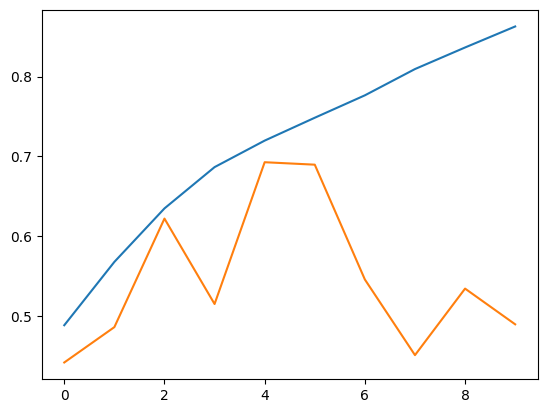

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

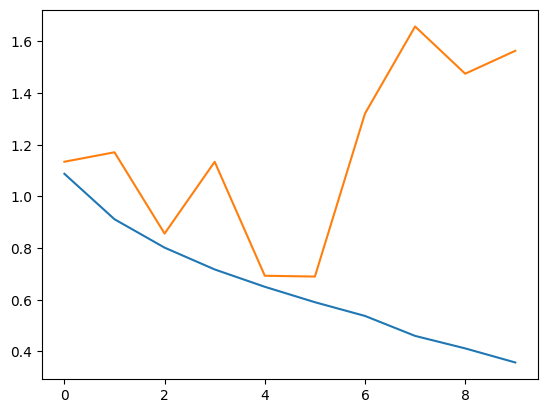

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])